In [1]:
CALI_PROCESSED = r"..\..\data\processed\florida_auto_processed.csv"
REPO_DIR = r"C:\Users\grego\Documents\GitHub\DS440CapstoneIndubitably"
MODEL_FP = r"C:\Users\grego\Documents\GitHub\DS440CapstoneIndubitably\models\knn_model.pkl"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append(REPO_DIR)
from app_new.feature_engineering import DemoClassifier
from dataclasses import dataclass
import numpy as np

@dataclass
class Feature:
    data: pd.DataFrame | np.ndarray
    col: str
    type: str
    models: dict | None
    params: dict | None

    def __str__(self):
        return f"{self.type} ({self.col}) - {self.params}"

    __repr__ = __str__

In [3]:
cali = pd.read_csv(CALI_PROCESSED)
cali.head()

,review_id,listing_id,description,comments,sentiment,label,name,amenities
0,4635158,42084,"['luxury', 'property', 'located', 'heart', 'ft...","['husband', 'enjoyed', 'stay', 'ft', 'lauderda...",4.500000,good,"['oceanview', 'luxury', 'hotel', 'suite']","['TV', 'Cable TV', 'Internet', 'Wifi', 'Air co..."
1,34416014,42084,"['luxury', 'property', 'located', 'heart', 'ft...","['karim', 'place', 'properly', 'advertised', '...",3.333333,good,"['oceanview', 'luxury', 'hotel', 'suite']","['TV', 'Cable TV', 'Internet', 'Wifi', 'Air co..."
2,81184393,42084,"['luxury', 'property', 'located', 'heart', 'ft...","['very', 'disappointed', 'rental', 'arrived', ...",1.500000,good,"['oceanview', 'luxury', 'hotel', 'suite']","['TV', 'Cable TV', 'Internet', 'Wifi', 'Air co..."
3,8485126,86410,"['great', 'studio', 'queen', 'bed', 'refrigera...","['great', 'studio', 'apartment', 'basic', 'no'...",4.000000,good,"['great', 'studio', 'block', 'beach']","['TV', 'Cable TV', 'Wifi', 'Air conditioning',..."
4,139833035,86410,"['great', 'studio', 'queen', 'bed', 'refrigera...","['gf', 'travelling', 'around', 'world', 'need'...",4.000000,good,"['great', 'studio', 'block', 'beach']","['TV', 'Cable TV', 'Wifi', 'Air conditioning',..."


In [4]:
clf = DemoClassifier(MODEL_FP)
y_pred, probabilities = clf.predict_all_processed(cali)

Loading models...
Predicting on 568 rows...
Processing row 1 of 568...
Generating amenities features...
Generating embedding features...
Generating pca features...
...without amenities
...without amenities
Processing row 2 of 568...
Generating amenities features...
Generating embedding features...
Generating pca features...
...without amenities
...without amenities
Processing row 3 of 568...
Generating amenities features...
Generating embedding features...
Generating pca features...
...without amenities
...without amenities
Processing row 4 of 568...
Generating amenities features...
Generating embedding features...
Generating pca features...
...without amenities
...without amenities
Processing row 5 of 568...
Generating amenities features...
Generating embedding features...
Generating pca features...
...without amenities
...without amenities
Processing row 6 of 568...
Generating amenities features...
Generating embedding features...
Generating pca features...
...without amenities
...wi

{'model': KNeighborsClassifier(leaf_size=10, n_neighbors=3), 'combo': (amenities (amenities) - {'corr_thresh': 0.05, 'amenities': ['amenity005_lockbox', 'amenity005_pool', 'amenity005_dishwasher', 'amenity005_tv', 'amenity005_keypad', 'amenity005_kitchen', 'amenity005_breakfast']}, pca (comments) - {'n_components': 10, 'vector_size': 50}, pca (description) - {'n_components': 5, 'vector_size': 200})}
Californian accuracy: 9.86%


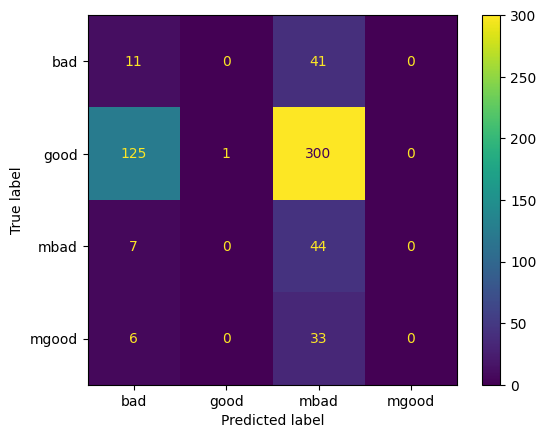

In [5]:
# plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = ConfusionMatrixDisplay.from_predictions(cali.label, y_pred)

# load model
with open(MODEL_FP, "rb") as f:
    model = pickle.load(f)

print(model)

# calculate the accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(cali.label, y_pred)
print(f"Californian accuracy: {accuracy:.2%}")

plt.show()